# Lista 12

## Exercício 23

Epoch 1000/100000, Loss: 1.2934, BLER: 0.0070
Epoch 2000/100000, Loss: 0.2462, BLER: 0.0020
Epoch 3000/100000, Loss: 0.0989, BLER: 0.0020
Epoch 4000/100000, Loss: 0.0484, BLER: 0.0010
Epoch 5000/100000, Loss: 0.0288, BLER: 0.0010
Epoch 6000/100000, Loss: 0.0199, BLER: 0.0010
Epoch 7000/100000, Loss: 0.0137, BLER: 0.0000
Epoch 8000/100000, Loss: 0.0117, BLER: 0.0010
Epoch 9000/100000, Loss: 0.0058, BLER: 0.0000
Epoch 10000/100000, Loss: 0.0060, BLER: 0.0000
Epoch 11000/100000, Loss: 0.0040, BLER: 0.0000
Epoch 12000/100000, Loss: 0.0086, BLER: 0.0020
Epoch 13000/100000, Loss: 0.0038, BLER: 0.0000
Epoch 14000/100000, Loss: 0.0060, BLER: 0.0030
Epoch 15000/100000, Loss: 0.0050, BLER: 0.0010
Epoch 16000/100000, Loss: 0.0044, BLER: 0.0010
Epoch 17000/100000, Loss: 0.0046, BLER: 0.0020
Epoch 18000/100000, Loss: 0.0040, BLER: 0.0010
Epoch 19000/100000, Loss: 0.0033, BLER: 0.0000
Epoch 20000/100000, Loss: 0.0052, BLER: 0.0010
Epoch 21000/100000, Loss: 0.0069, BLER: 0.0020
Epoch 22000/100000, Lo

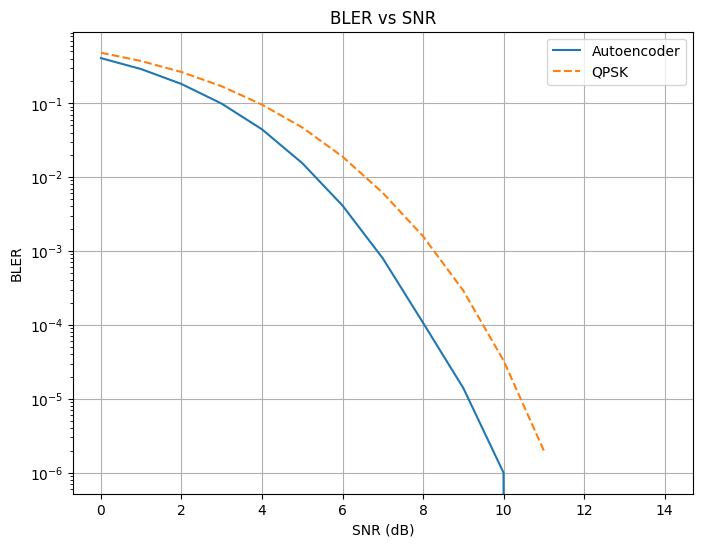

In [2]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

tf.disable_v2_behavior()

k = 8
n = 8
M = 2**k
batch_size = tf.placeholder(dtype=tf.int32, shape=[])
noise_std = tf.placeholder(dtype=tf.float32, shape=[])
learning_rate = tf.placeholder(dtype=tf.float32, shape=[])

s = tf.random.uniform(shape=[batch_size], minval=0, maxval=M, dtype=tf.int32)
s_one_hot = tf.one_hot(s, depth=M)

tx = tf.keras.layers.Dense(M, activation='relu')(s_one_hot)
tx = tf.keras.layers.Dense(n, activation=None)(tx)

tx = tx / tf.sqrt(tf.reduce_mean(tf.square(tx), axis=1, keepdims=True))

noise = tf.random.normal(shape=tf.shape(tx), stddev=noise_std)
rx = tx + noise

rx = tf.keras.layers.Dense(M, activation='relu')(rx)
s_hat = tf.keras.layers.Dense(M, activation=None)(rx)

cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(s_hat), axis=1, output_type=tf.int32), s)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))
bler = 1.0 - accuracy

train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

def EbNo2Sigma(ebnodb):
    ebno = 10 ** (ebnodb / 10)
    bits_per_complex_symbol = k / (n / 2)
    return 1.0 / np.sqrt(bits_per_complex_symbol * ebno)

num_epochs = 100000
batch_size_value = 1000
lr_value = 0.0001
snr_train = 7.0
sigma_train = EbNo2Sigma(snr_train)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(num_epochs):
        _, loss_value, bler_value = sess.run(
            [train_op, cross_entropy, bler],
            feed_dict={
                batch_size: batch_size_value,
                noise_std: sigma_train,
                learning_rate: lr_value
            }
        )
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_value:.4f}, BLER: {bler_value:.4f}")

    snr_range = np.arange(0, 15, 1)
    bler_results = []

    for snr in snr_range:
        sigma_test = EbNo2Sigma(snr)
        total_bler = 0

        for _ in range(10):
            bler_test = sess.run(
                bler,
                feed_dict={
                    batch_size: 100000,
                    noise_std: sigma_test
                }
            )
            total_bler += bler_test

        bler_results.append(total_bler / 10)
        print(f"SNR: {snr} dB, BLER: {bler_results[-1]:.4f}")

BLER_QPSK = np.array([
    4.80998e-01, 3.71098e-01, 2.63797e-01, 1.68919e-01, 9.54540e-02,
    4.68860e-02, 1.89070e-02, 6.11700e-03, 1.58300e-03, 2.91000e-04,
    3.30000e-05, 2.00000e-06
])

plt.figure(figsize=(8, 6))
plt.semilogy(snr_range, bler_results, label='Autoencoder')
plt.semilogy(range(0, len(BLER_QPSK)), BLER_QPSK, label='QPSK', linestyle='--')
plt.xlabel('SNR (dB)')
plt.ylabel('BLER')
plt.title('BLER vs SNR')
plt.legend()
plt.grid()
plt.show()